# Binary Classification of Machine Failures

"The dataset for this competition (both train and test) was generated from a deep learning model trained on the Machine Failure Predictions."

The **aim** is to predict the label "machine failure" (0/1)

**Evaluation**: Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

**Sources**:

- [Kaggle challenge](https://www.kaggle.com/competitions/playground-series-s3e17/data?select=train.csv)
- [Original Dataset](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions)

# Outline
- [ 1 - Read Data ](#1) 
- [ 2 - EDA - Exploratory Data Analysis](#2)
- [ 3 - Preprocessing Data Before Modeling](#3)
- [ 4 - Model Training](#4)
- [ 5 - Model Comparison](#5)
- [ 6 - Model Tuning](#6)
- [ 7 - Model Diagnostic](#7)
- [ 8 - Challenge Submission](#8)

In [127]:
# importing standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, LearningCurveDisplay, ShuffleSplit

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'axes.titlesize': 16,
    'figure.figsize': (12, 4),
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('colorblind'), 
              rc=theme_parameters)

<a name="1"></a>
# Read Data

In [4]:
read_from_kaggle = False

In [18]:
if read_from_kaggle:
    
    data = pd.read_csv('',
                       index_col=0)
    test_data = pd.read_csv('',
                       index_col=0)
    orig_data = pd.read_csv('',
                            index_col=0)
    
    
else:

    train_data = pd.read_csv("./../data/machine_failure_train.csv",
                             index_col=0)
    test_data = pd.read_csv("./../data/machine_failure_test.csv",
                            index_col=0)
    orig_data = pd.read_csv("./../data/machine_failure_original.csv",
                            index_col=0)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


In [13]:
train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90954 entries, 136429 to 227382
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               90954 non-null  object 
 1   Type                     90954 non-null  object 
 2   Air temperature [K]      90954 non-null  float64
 3   Process temperature [K]  90954 non-null  float64
 4   Rotational speed [rpm]   90954 non-null  int64  
 5   Torque [Nm]              90954 non-null  float64
 6   Tool wear [min]          90954 non-null  int64  
 7   TWF                      90954 non-null  int64  
 8   HDF                      90954 non-null  int64  
 9   PWF                      90954 non-null  int64  
 10  OSF                      90954 non-null  int64  
 11  RNF                      90954 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 9.0+ MB


In [14]:
test_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [19]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1.1+ MB


In [20]:
orig_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Defining Categorical Dtype

In [39]:
# List of datasets
datasets = [train_data, test_data, orig_data]

# Columns to convert to categorical
columns = ['Type']

for dataset in datasets:
    for column in columns:
        dataset[column] = dataset[column].astype('category')

<a name="2"></a>
# EDA - Exploratory Data Analysis

## Numeric Feature Distribution Train vs Test vs Original Data KDEs

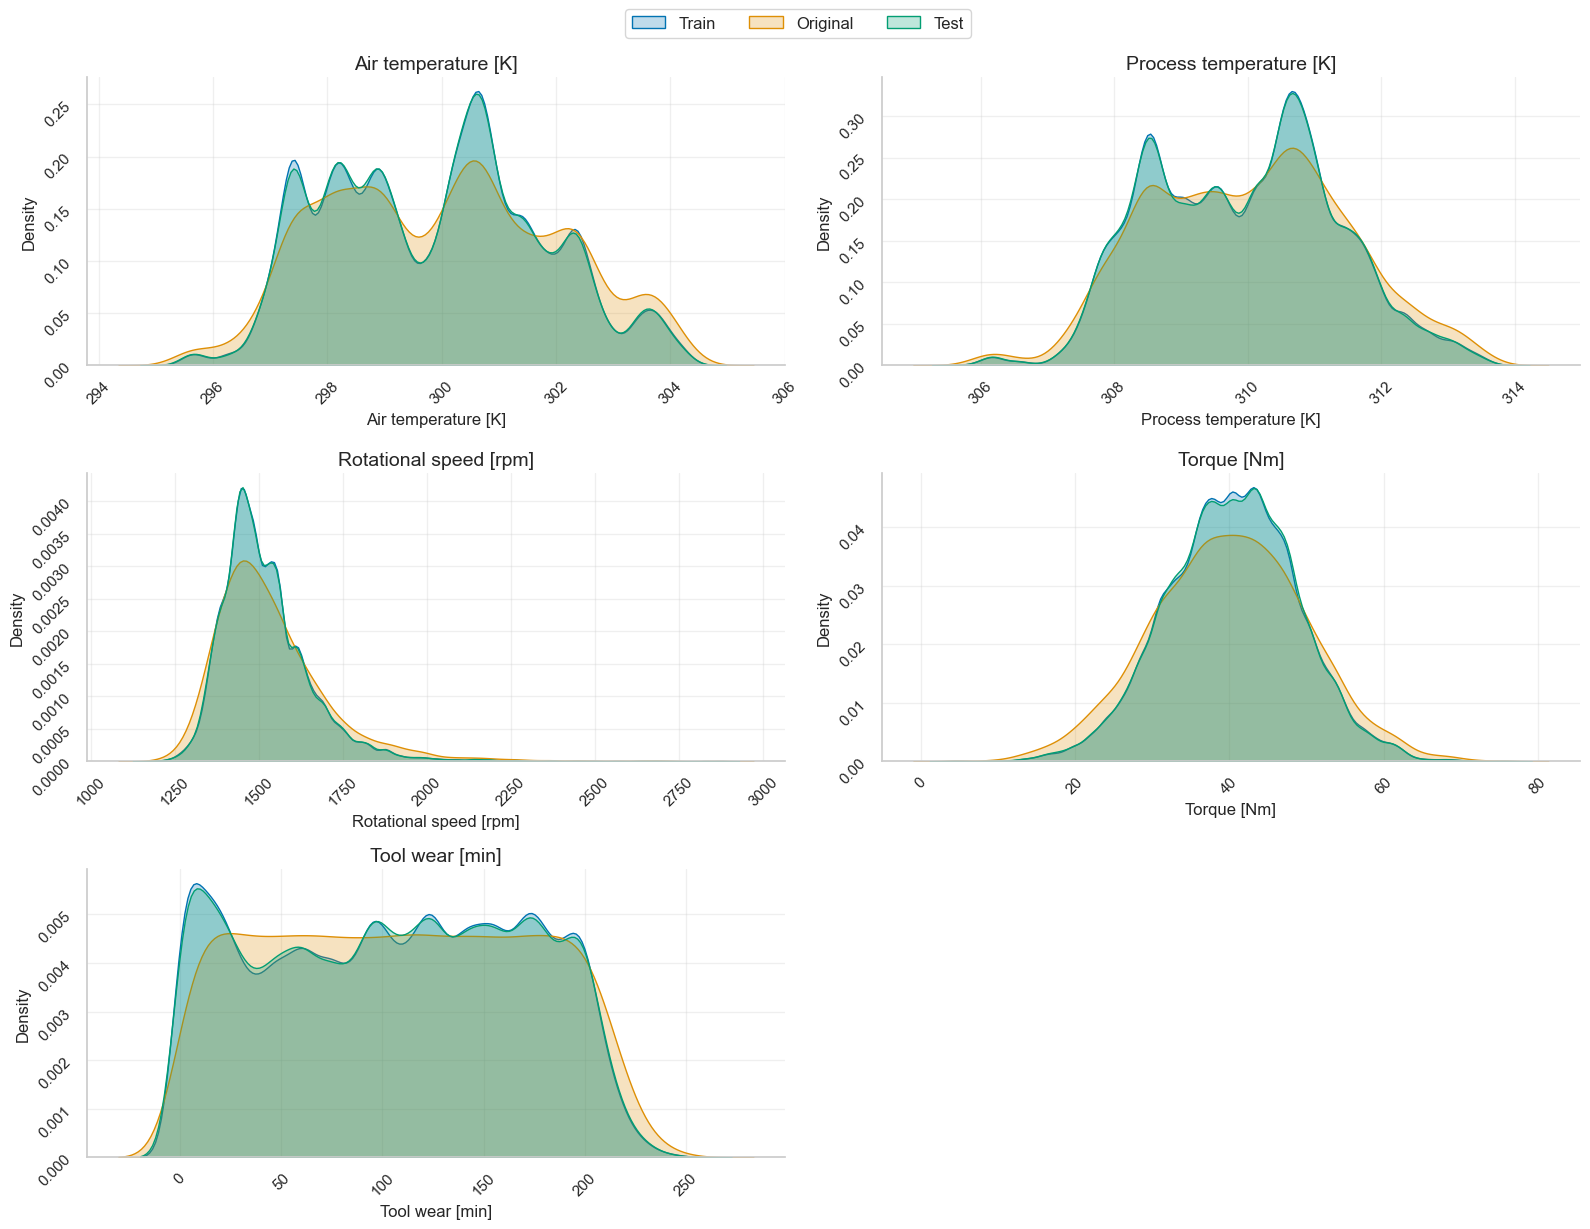

In [33]:
figure, ax = plt.subplots(3, 2, figsize=(16, 12))
ax = ax.flatten()

# create a list to exclude categorical features and the label
exclude_columns = ['Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

for index, col_name in enumerate([col for col in train_data.columns if col not in exclude_columns]):
    
    sns.kdeplot(data=train_data[col_name],
                label='Train',
                fill=True,
                ax=ax[index])
    
    sns.kdeplot(data=orig_data[col_name],
                label='Original',
                fill=True,
                ax=ax[index])
    
    sns.kdeplot(data=test_data[col_name],
                label='Test',
                fill=True,
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplots
figure.delaxes(ax[-1])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

plt.tight_layout()
plt.show()

## Label Distribution Challenge vs Original Data KDEs

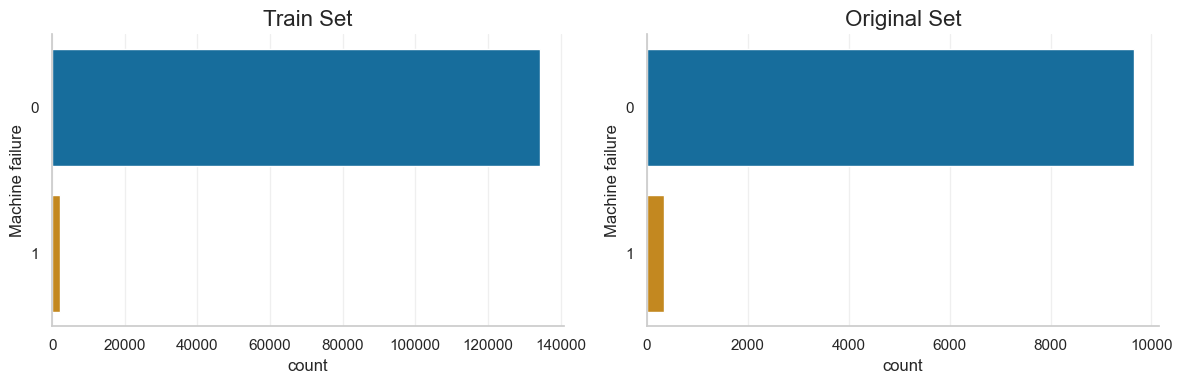

In [27]:
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.flatten()

sns.countplot(data=train_data.sort_values('Machine failure'), 
              y="Machine failure",
              ax=ax[0])

sns.countplot(data=orig_data.sort_values('Machine failure'), 
              y="Machine failure",
              ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Original Set')

plt.tight_layout()
plt.show()

## Categorical Features

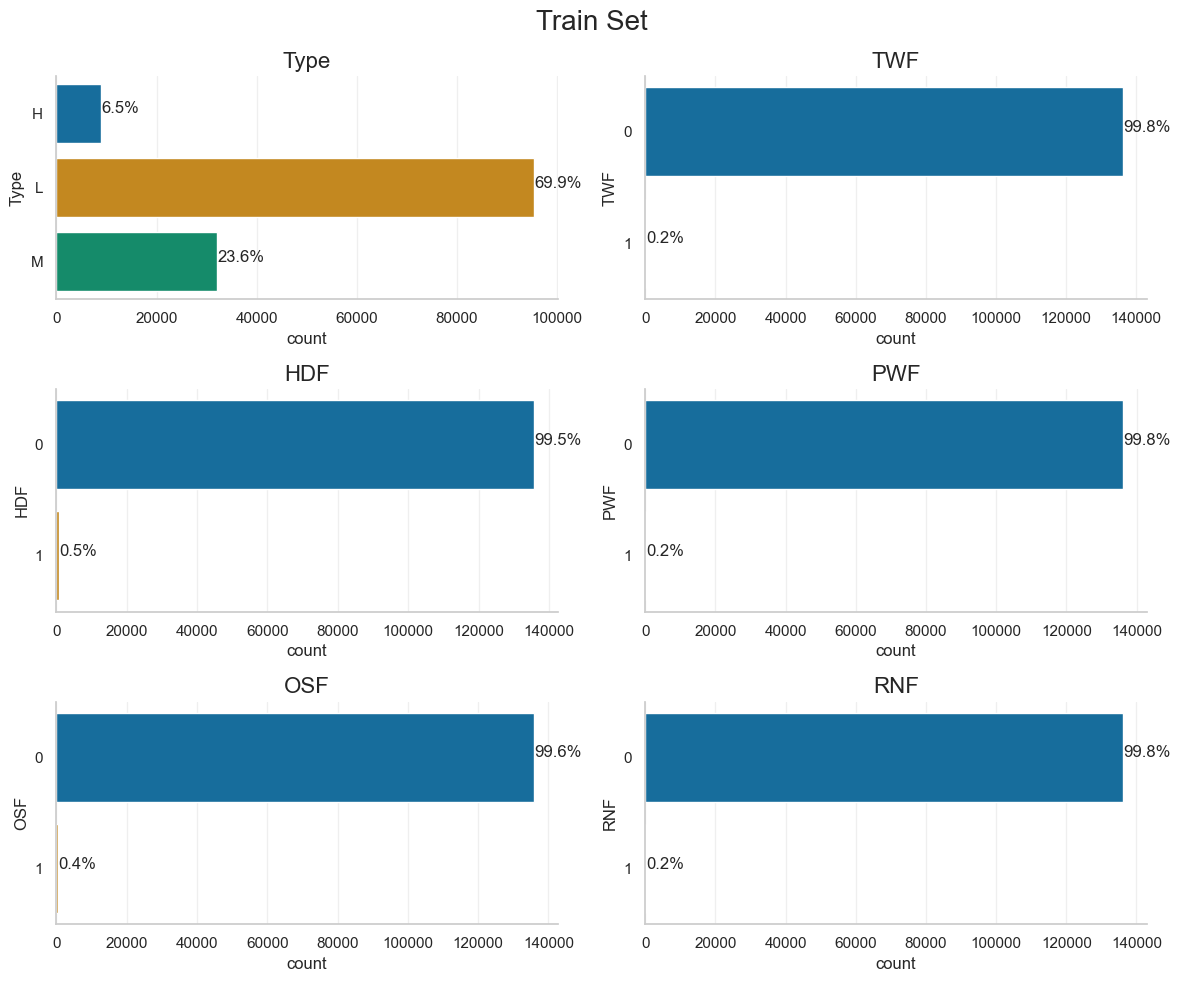

In [57]:
figure, ax = plt.subplots(3, 2, figsize=(12, 10))
ax = ax.flatten()

# Select the categorical columns for plotting
categorical_columns = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


for index, col_name in enumerate(categorical_columns):
    sns.countplot(data=train_data.sort_values(col_name), 
                  y=col_name, 
                  ax=ax[index])

    ax[index].set_title(col_name)

    # Add percentage labels
    total = float(len(train_data[col_name]))
    for p in ax[index].patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax[index].annotate(percentage, (x, y))

plt.suptitle('Train Set', fontsize=20)    
    
plt.tight_layout()
plt.show()

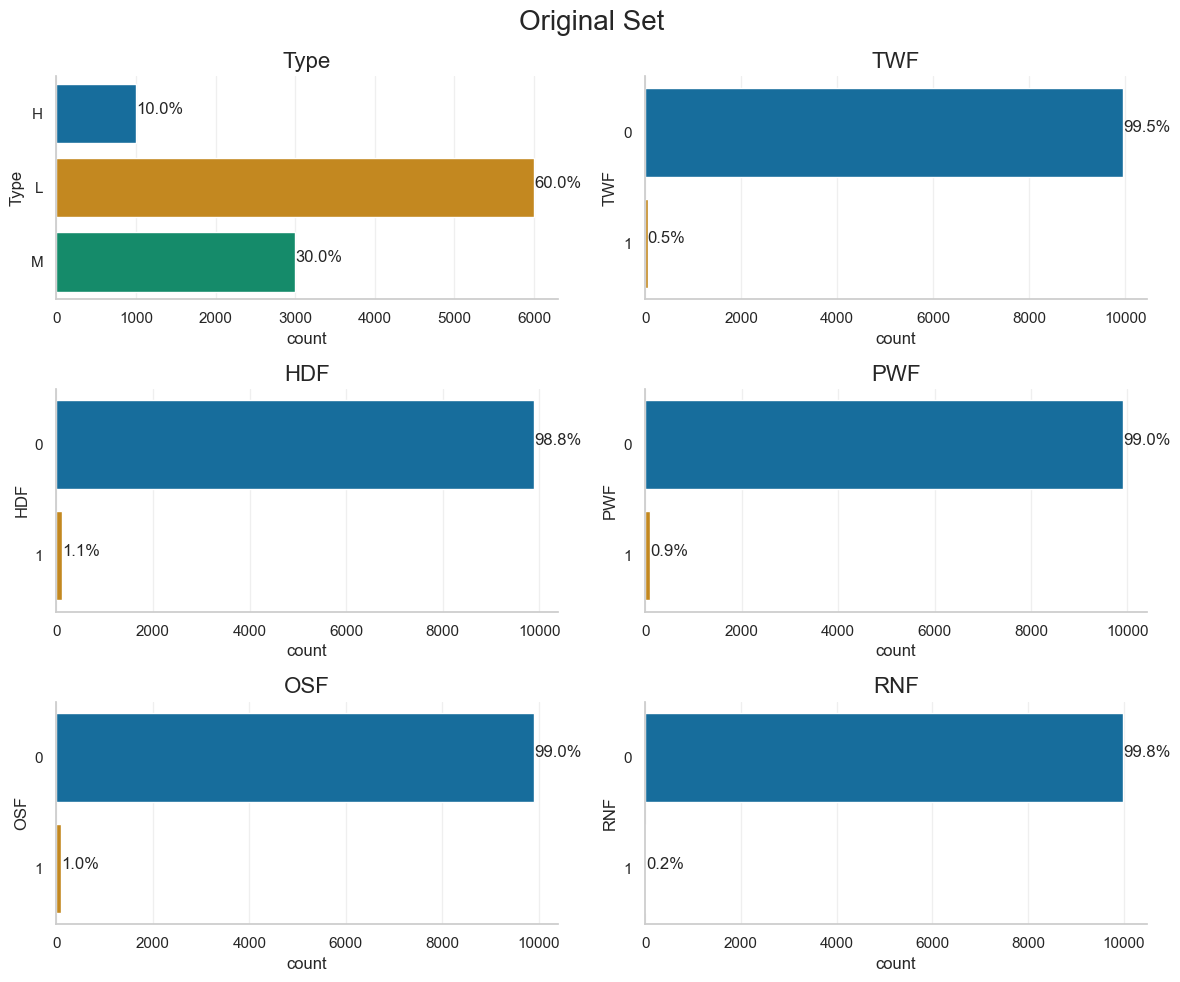

In [55]:
figure, ax = plt.subplots(3, 2, figsize=(12, 10))
ax = ax.flatten()

# Select the categorical columns for plotting
categorical_columns = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


for index, col_name in enumerate(categorical_columns):
    sns.countplot(data=orig_data.sort_values(col_name), 
                  y=col_name, 
                  ax=ax[index])

    ax[index].set_title(col_name)

    # Add percentage labels
    total = float(len(orig_data[col_name]))
    for p in ax[index].patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax[index].annotate(percentage, (x, y))

plt.suptitle('Original Set', fontsize=20)    
    
plt.tight_layout()
plt.show()

## Boxplot Numerical Features vs Type

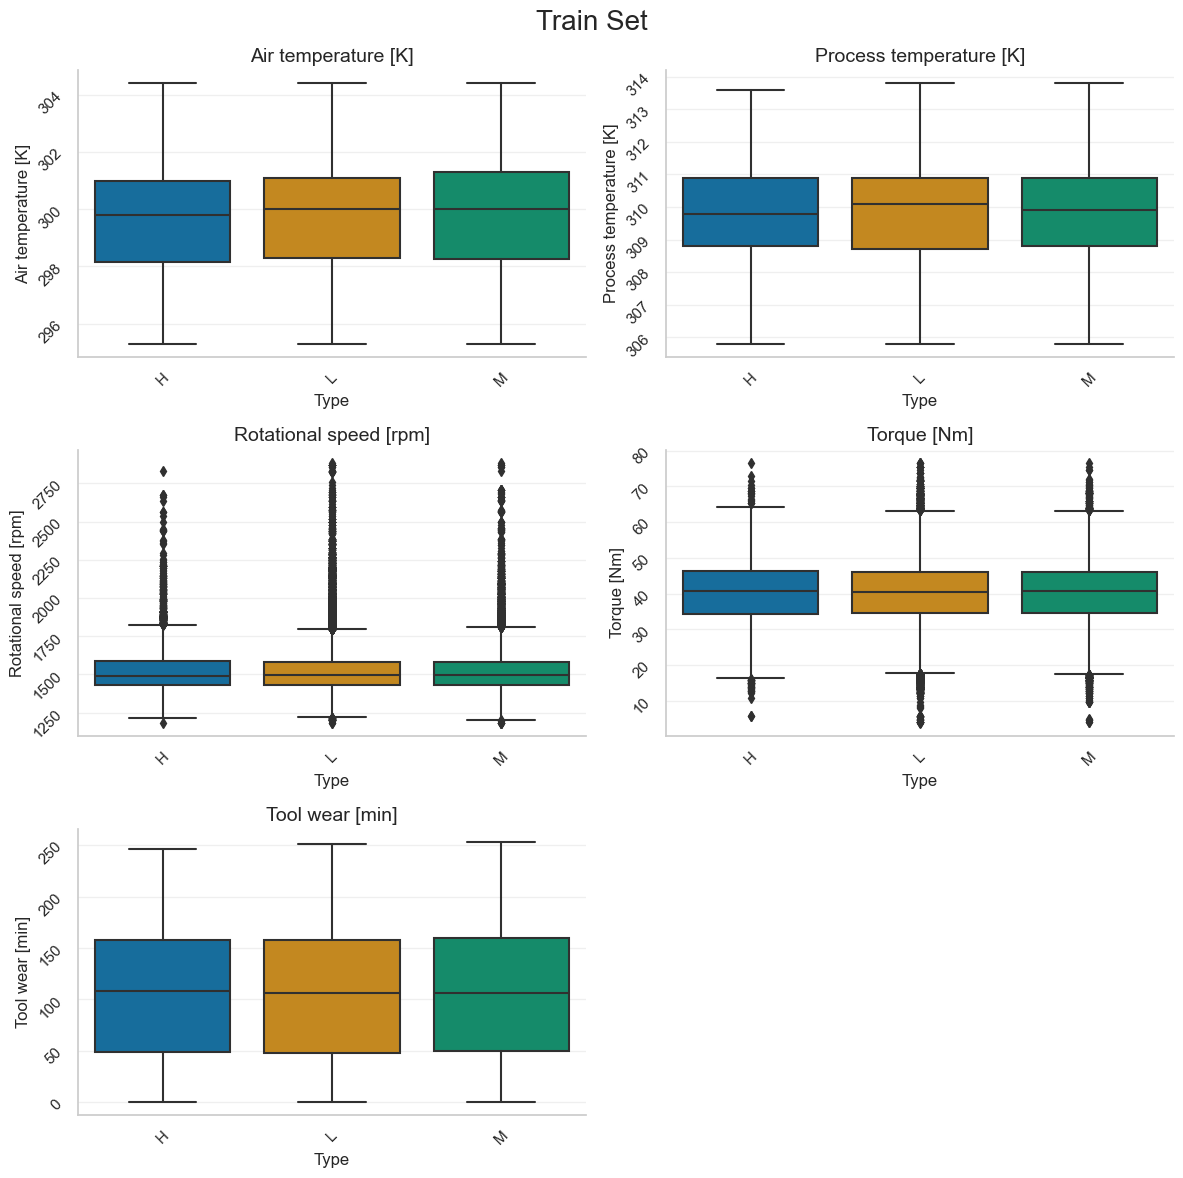

In [50]:
figure, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.flatten()

# create a list to exclude categorical features and the label
exclude_columns = ['Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

for index, col_name in enumerate([col for col in train_data.columns if col not in exclude_columns]):
    
    sns.boxplot(data=train_data,
                x='Type',
                y=col_name,
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)

plt.suptitle('Train Set', fontsize=20)

# Remove the empty subplots
figure.delaxes(ax[-1])
    
plt.tight_layout()
plt.show()

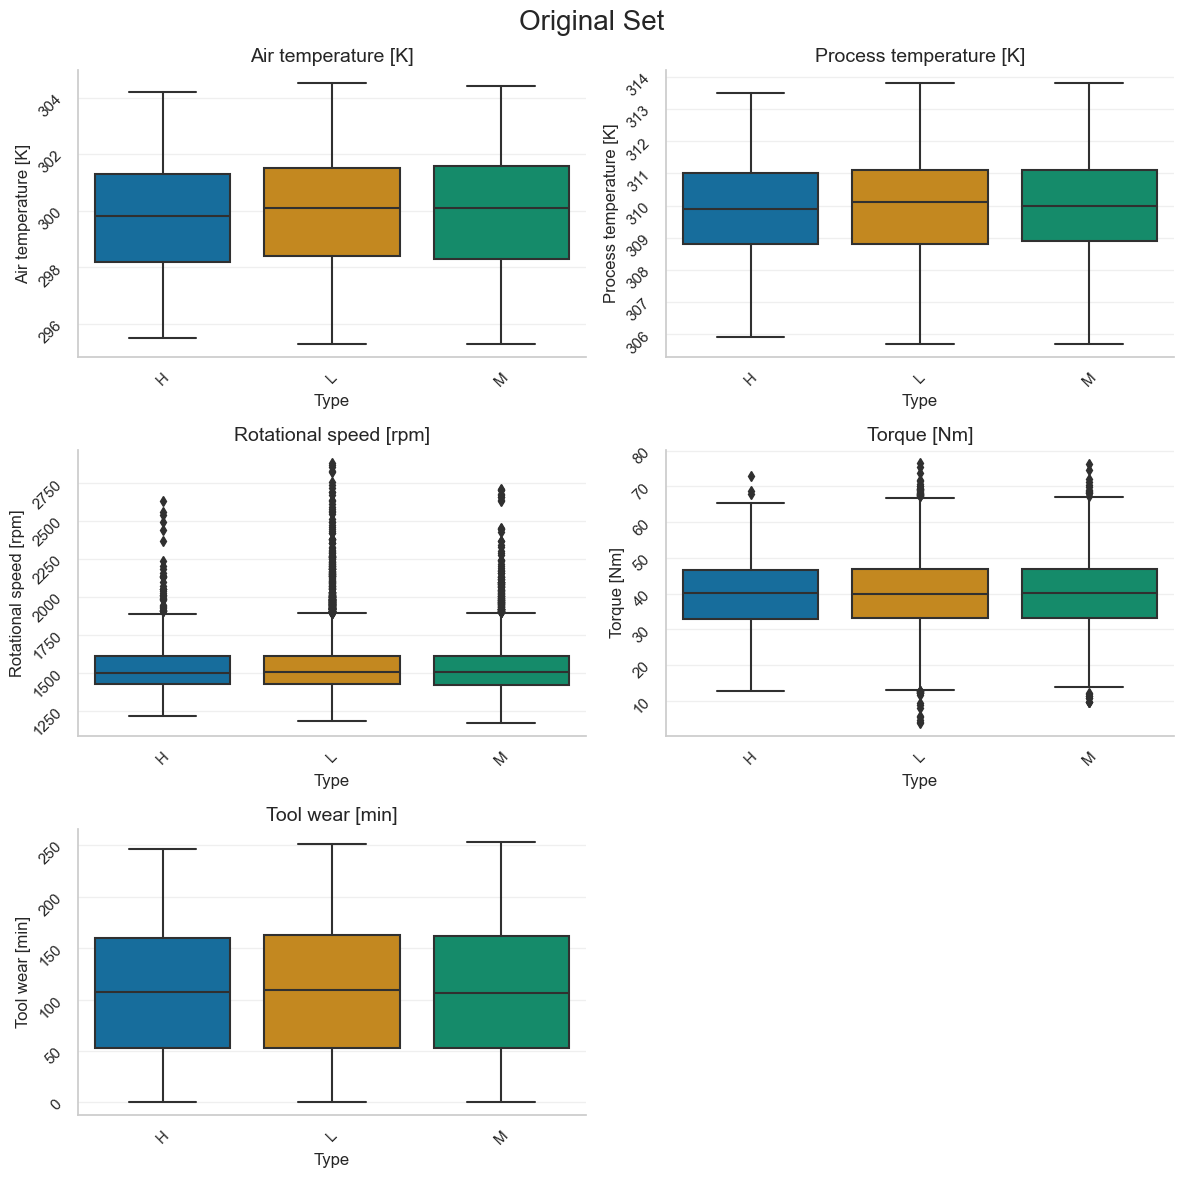

In [51]:
figure, ax = plt.subplots(3, 2, figsize=(12, 12))
ax = ax.flatten()

# create a list to exclude categorical features and the label
exclude_columns = ['Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

for index, col_name in enumerate([col for col in orig_data.columns if col not in exclude_columns]):
    
    sns.boxplot(data=orig_data,
                x='Type',
                y=col_name,
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)

plt.suptitle('Original Set', fontsize=20)

# Remove the empty subplots
figure.delaxes(ax[-1])
    
plt.tight_layout()
plt.show()

## Pairplots

In [59]:
train_data.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

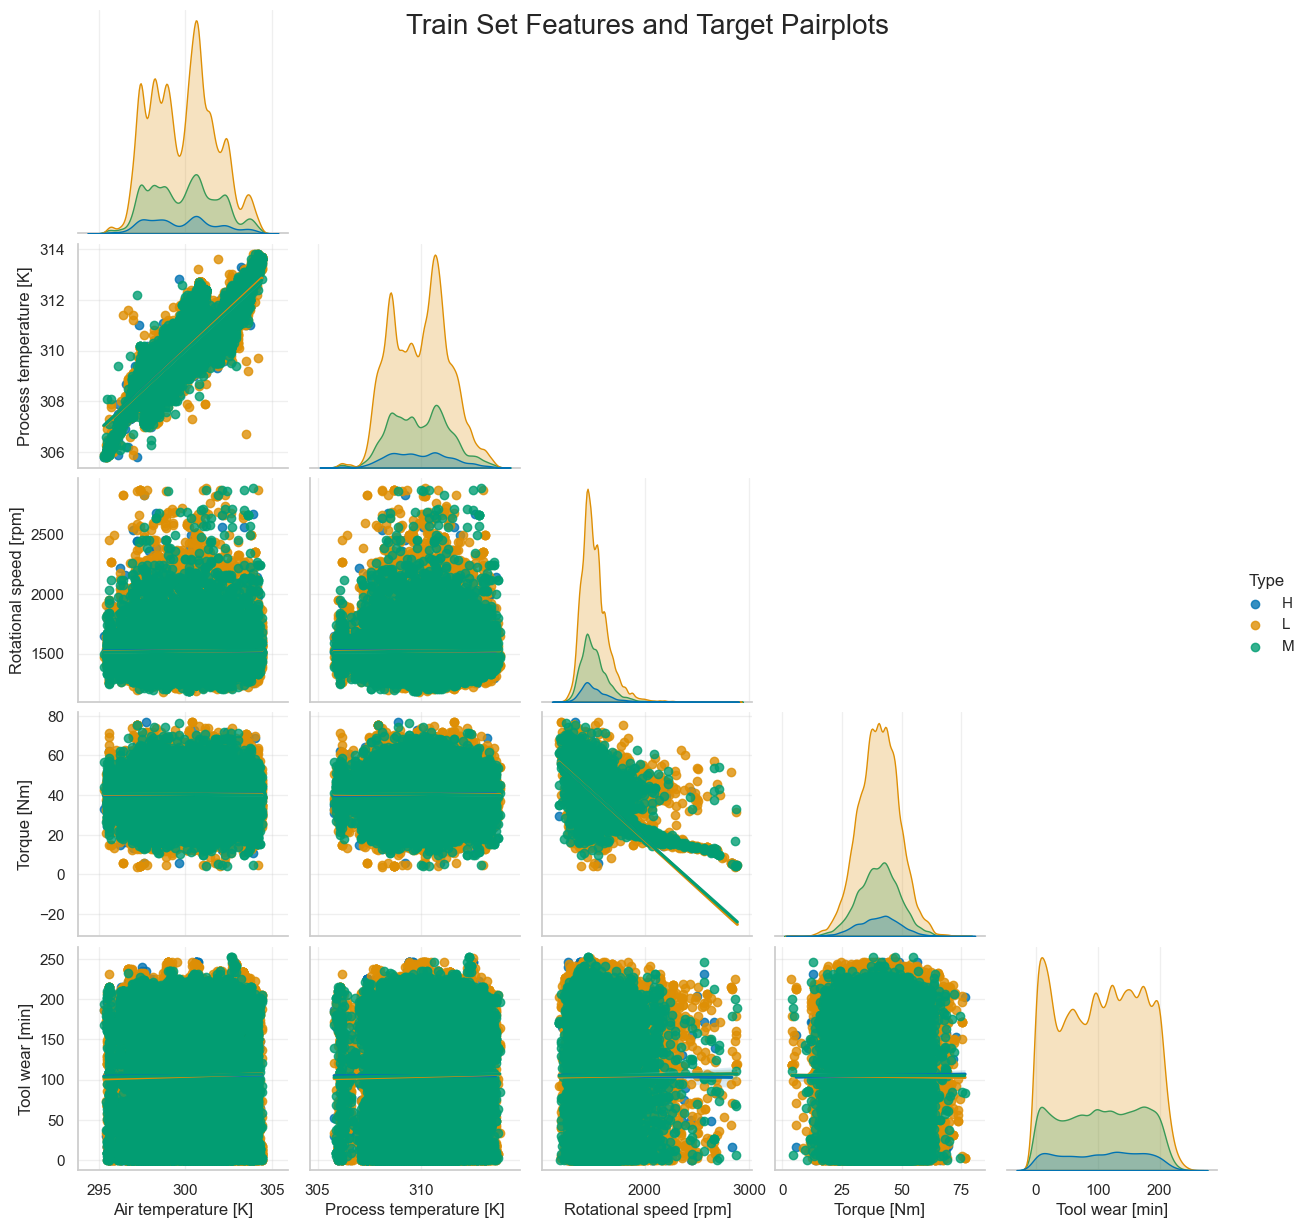

In [64]:
sns.pairplot(train_data[['Type', 
                        'Air temperature [K]', 
                        'Process temperature [K]',
                        'Rotational speed [rpm]', 
                        'Torque [Nm]', 
                        'Tool wear [min]']],
             hue='Type',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Train Set Features and Target Pairplots', 
             fontsize=20)

plt.show()

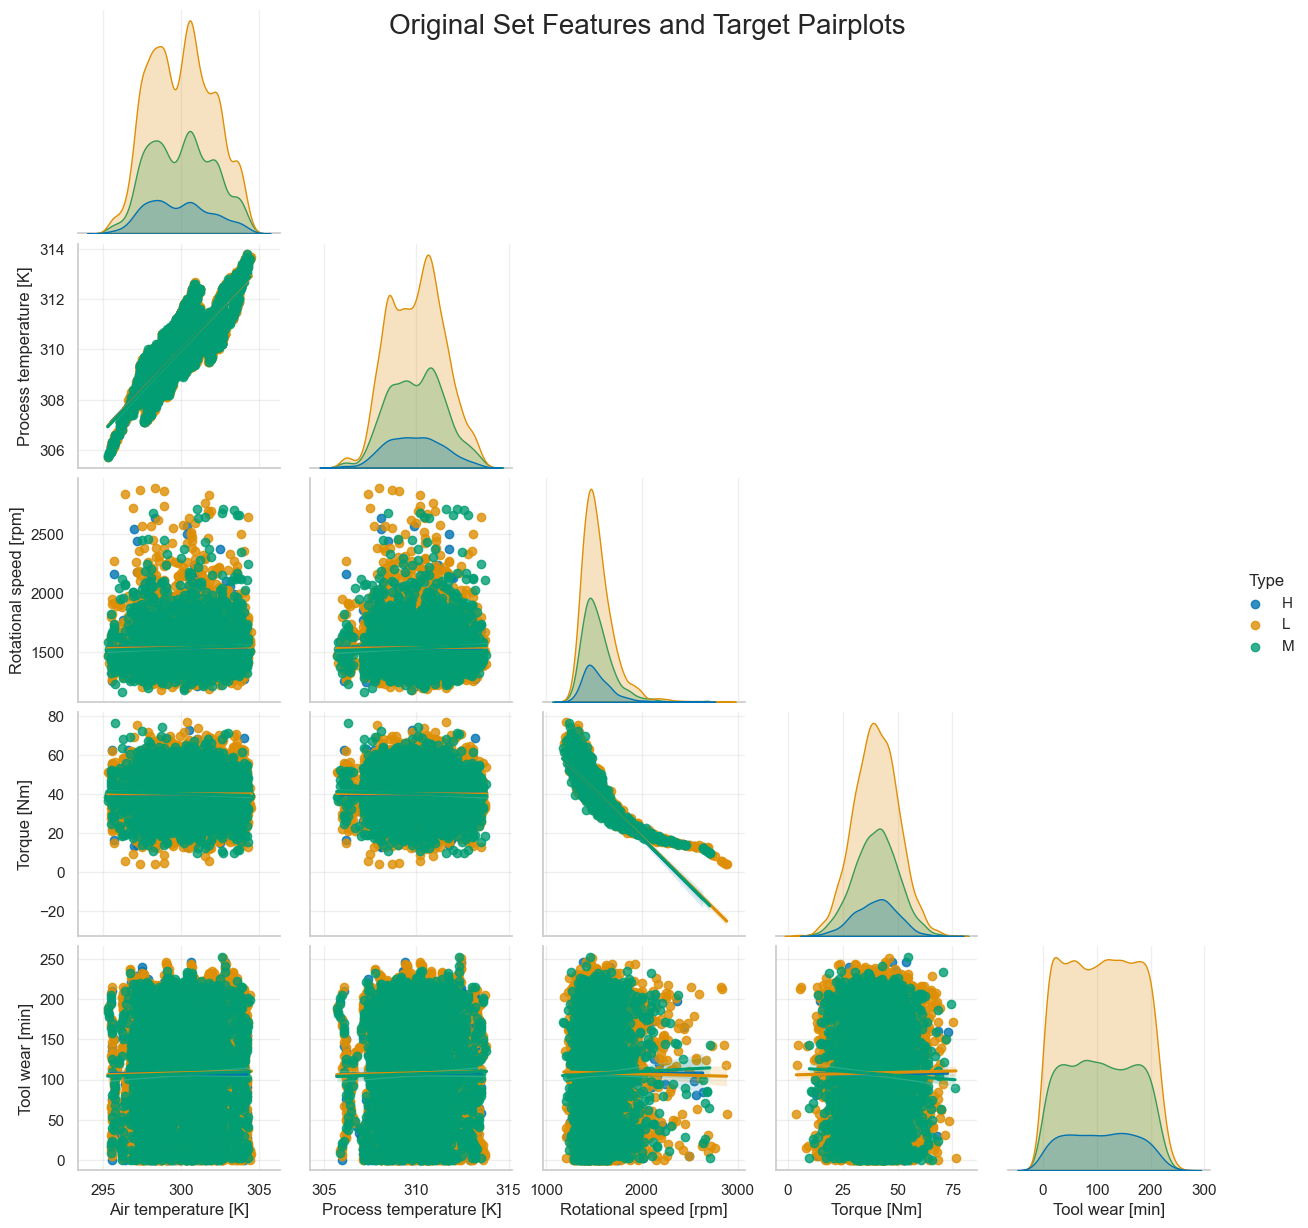

In [65]:
sns.pairplot(orig_data[['Type', 
                        'Air temperature [K]', 
                        'Process temperature [K]',
                        'Rotational speed [rpm]', 
                        'Torque [Nm]', 
                        'Tool wear [min]']],
             hue='Type',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Original Set Features and Target Pairplots', 
             fontsize=20)

plt.show()

## Pearson vs Spearman Correlation Matrix

In [67]:
train_data.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [69]:
# Define columns to use in correlation matrix
corr_columns = ['Air temperature [K]', 
                'Process temperature [K]',
                'Rotational speed [rpm]', 
                'Torque [Nm]', 
                'Tool wear [min]']

In [71]:
# Generate correlation matrix train set
correlation_train = train_data[corr_columns].corr(method='pearson')

# Generate a mask for the upper triangle
correlation_mask_train = np.triu(np.ones_like(correlation_train, dtype=bool))

# Generate correlation matrix original set
correlation_orig = orig_data[corr_columns].corr(method='pearson')

# Generate a mask for the upper triangle
correlation_mask_orig = np.triu(np.ones_like(correlation_orig, dtype=bool))

# Generate correlation matrix test set
correlation_test = test_data[corr_columns].corr(method='pearson')

# Generate a mask for the upper triangle
correlation_mask_test = np.triu(np.ones_like(correlation_test, dtype=bool))

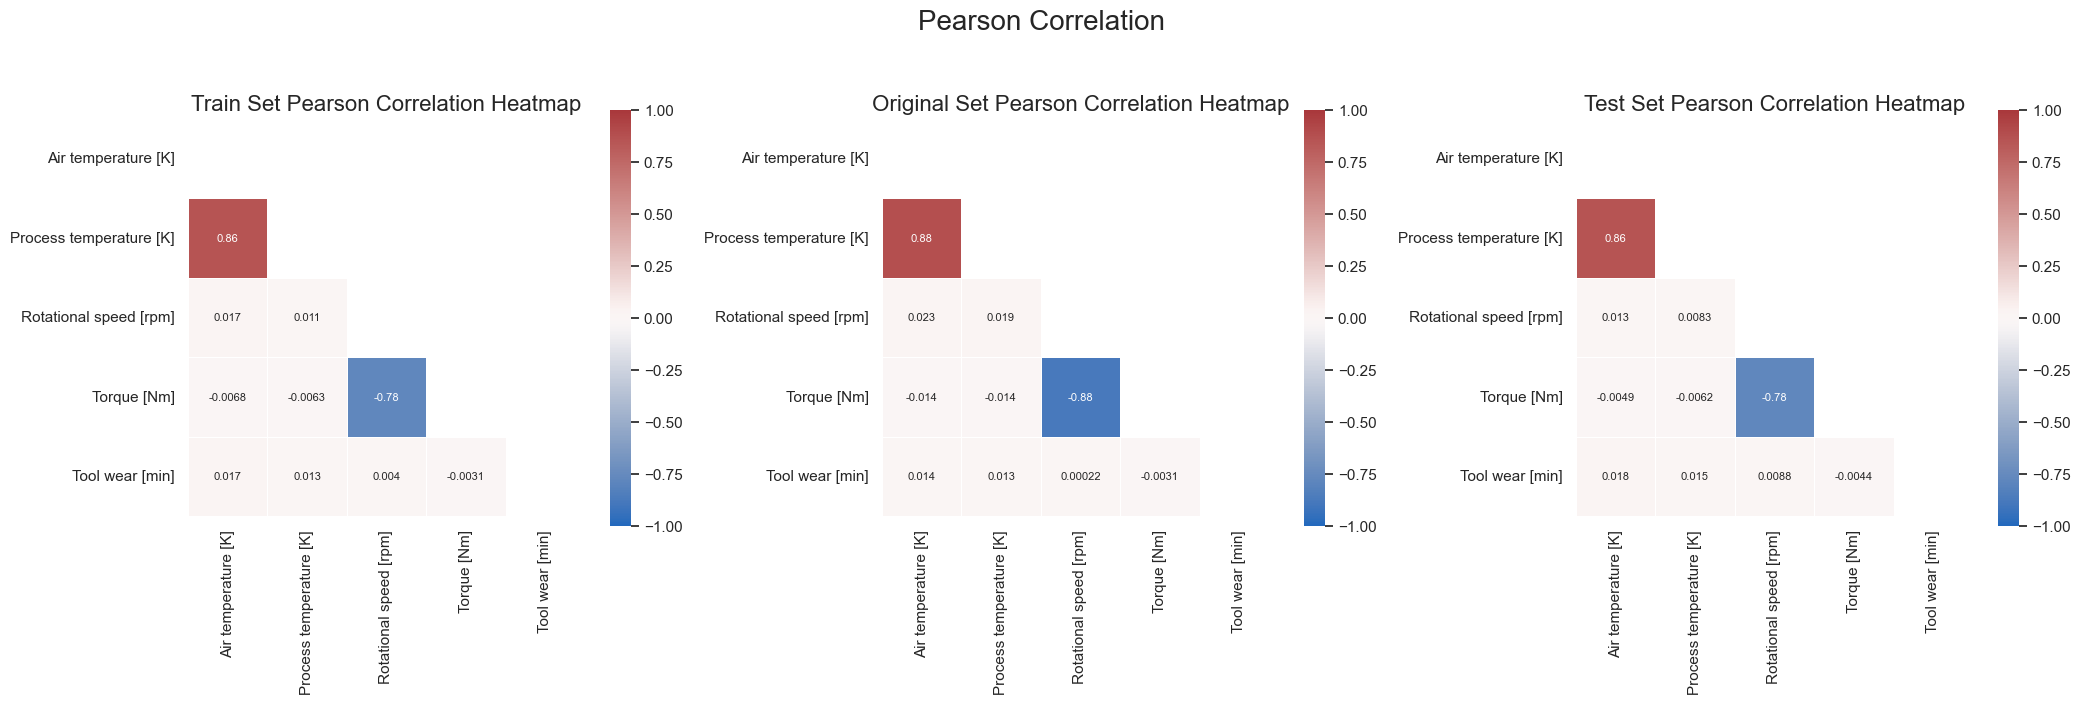

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax = ax.flatten()

# Define lost to iterate on
datasets = [(correlation_train, correlation_mask_train, 'Train Set Pearson Correlation Heatmap'),
            (correlation_orig, correlation_mask_orig, 'Original Set Pearson Correlation Heatmap'),
            (correlation_test, correlation_mask_test, 'Test Set Pearson Correlation Heatmap')]

for i, (correlation_data, correlation_mask, title) in enumerate(datasets):
    sns.heatmap(correlation_data,
                mask=correlation_mask,
                cmap='vlag',
                vmax=1.0,
                vmin=-1.0,
                center=0,
                square=True,
                linewidths=.5,
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink": .8, 'orientation': 'vertical'},
                ax=ax[i])
    ax[i].set_title(title)
    
plt.suptitle('Pearson Correlation', fontsize=20)    
    
plt.tight_layout()
plt.show()

In [73]:
# Generate correlation matrix train set
correlation_train = train_data[corr_columns].corr(method='spearman')

# Generate a mask for the upper triangle
correlation_mask_train = np.triu(np.ones_like(correlation_train, dtype=bool))

# Generate correlation matrix original set
correlation_orig = orig_data[corr_columns].corr(method='spearman')

# Generate a mask for the upper triangle
correlation_mask_orig = np.triu(np.ones_like(correlation_orig, dtype=bool))

# Generate correlation matrix test set
correlation_test = test_data[corr_columns].corr(method='spearman')

# Generate a mask for the upper triangle
correlation_mask_test = np.triu(np.ones_like(correlation_test, dtype=bool))

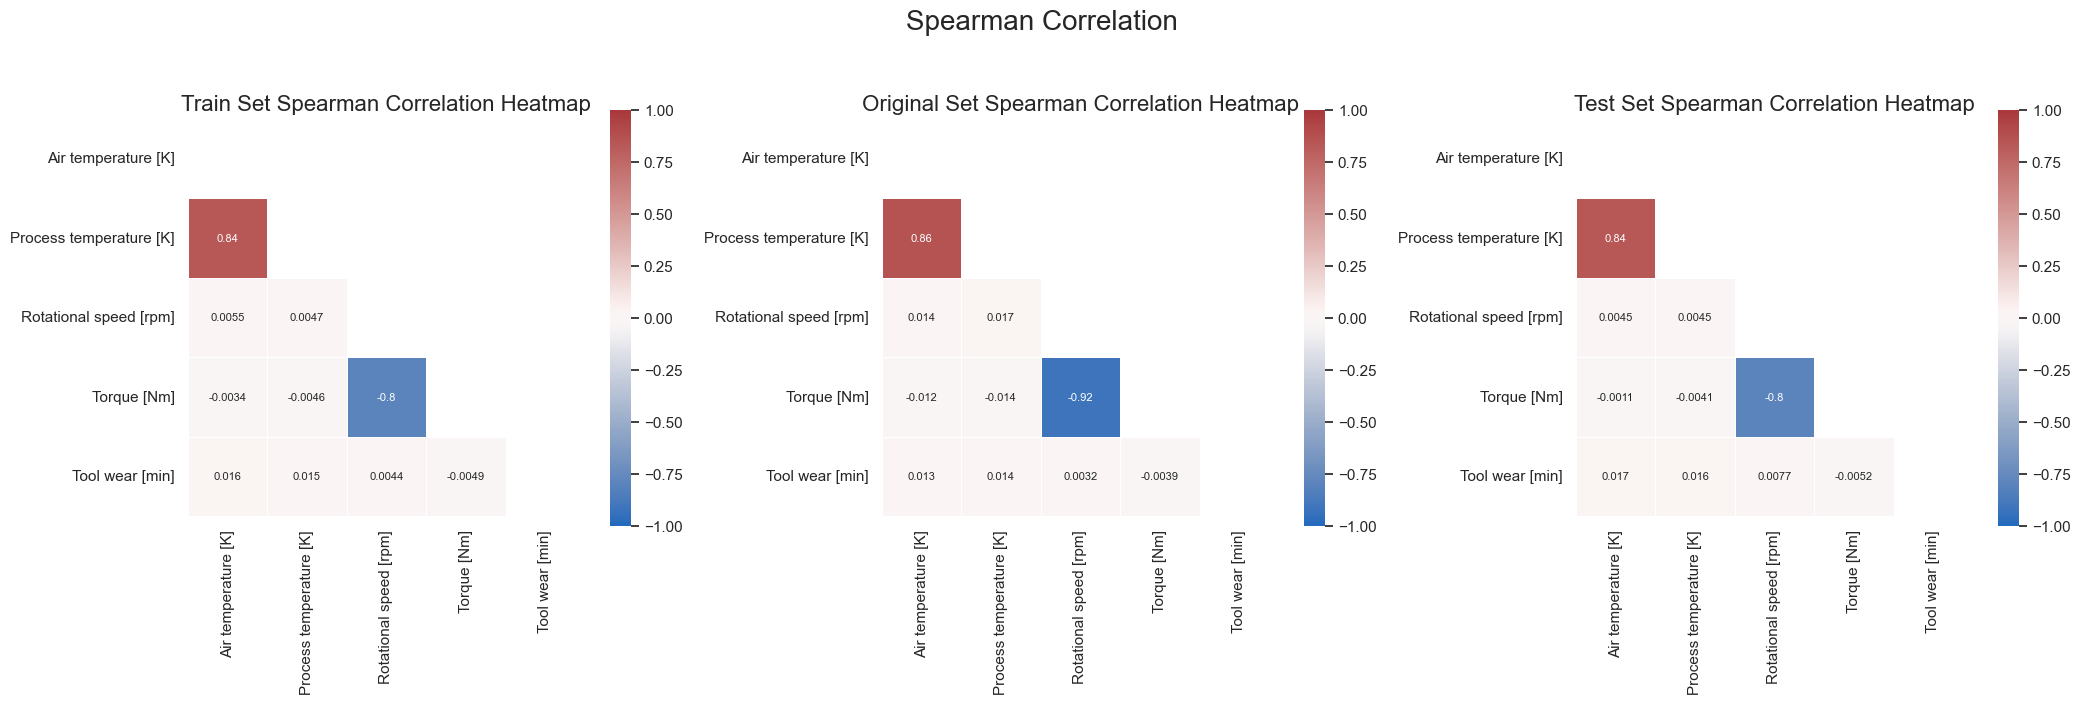

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax = ax.flatten()

# Define lost to iterate on
datasets = [(correlation_train, correlation_mask_train, 'Train Set Spearman Correlation Heatmap'),
            (correlation_orig, correlation_mask_orig, 'Original Set Spearman Correlation Heatmap'),
            (correlation_test, correlation_mask_test, 'Test Set Spearman Correlation Heatmap')]

for i, (correlation_data, correlation_mask, title) in enumerate(datasets):
    sns.heatmap(correlation_data,
                mask=correlation_mask,
                cmap='vlag',
                vmax=1.0,
                vmin=-1.0,
                center=0,
                square=True,
                linewidths=.5,
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink": .8, 'orientation': 'vertical'},
                ax=ax[i])
    ax[i].set_title(title)

plt.suptitle('Spearman Correlation', fontsize=20)        
    
plt.tight_layout()
plt.show()

## Conclusions

- We see that the fail categories in the features and in the label are **highly unbalanced**. Accuracy score won't be meaningful
- The machines looks to operate in the same range of condistions despite the type

### Whats nexts

# Data Preprocessing

## Renaming Columns

Some libraries like XGBoost don't work with special characters like [ ], so let's remove them from the columns name 

In [79]:
train_data.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [80]:
# Define a dictionary with new column names
new_column_names = {'Air temperature [K]' : 'Air temperature', 
                    'Process temperature [K]' : 'Process temperature',
                    'Rotational speed [rpm]' : 'Rotational speed', 
                    'Torque [Nm]' : 'Torque', 
                    'Tool wear [min]' : 'Tool wear'}

# Rename the columns
train_data = train_data.rename(columns=new_column_names)

test_data = test_data.rename(columns=new_column_names)

orig_data = orig_data.rename(columns=new_column_names)

In [82]:
def compute_engineered_features(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    Create engineered features to have the dataset model-ready
    
    Args:
        data Pandas.DataFrame input
    
    Returns:
        data Pandas.DataFrame with engineered features
    """
    
    # Create engineered features
    # Create a new columns to distinguish 'young' (U) vs "adult" (A) crabs
    data['Air temperature per Process temperature']  = data['Air temperature'] * data['Process temperature'] 
    
    data['Temperature ratio'] = data['Process temperature'] / data['Air temperature']
    
    data['Toque per Rotational speed'] = data['Torque'] * data['Rotational speed']
    
    data['Torque Rotational speed ratio'] = data['Torque'] / data['Rotational speed']
         
    data['Failure sum'] = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)
         
    return data

In [83]:
# Engineering features in train data
train_data = compute_engineered_features(train_data.copy())

# Engineering features in original data
orig_data = compute_engineered_features(orig_data.copy())

# Engineering features in test data
test_data = compute_engineered_features(test_data.copy())

## Concatenate Training and Original Datasets

In [86]:
full_train_data = pd.concat([train_data, orig_data], axis=0)

## Defining Features and Label

In [87]:
full_train_data.columns

Index(['Product ID', 'Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear', 'Machine failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Air temperature per Process temperature',
       'Temperature ratio', 'Toque per Rotational speed',
       'Torque Rotational speed ratio', 'Failure sum'],
      dtype='object')

In [92]:
numerical_features = ['Air temperature', 
                      'Process temperature',
                      'Rotational speed', 
                      'Torque', 
                      'Tool wear', 
                      'Air temperature per Process temperature',
                      'Temperature ratio', 
                      'Toque per Rotational speed',
                      'Torque Rotational speed ratio', 
                      'Failure sum']

categorical_features = ['Type',
                        'TWF',
                        'HDF', 
                        'PWF', 
                        'OSF', 
                        'RNF']

label = ['Machine failure']

## Scale and Normalize Numerical Features

In [90]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transformer', PowerTransformer())
])

# Fit and transform the train data using the pipeline
transformed_train_data = pd.DataFrame(pipeline.fit_transform(full_train_data[numerical_features]))

# Scaling removed column names - put them back
transformed_train_data.columns = numerical_features

# Reset index
transformed_train_data.index = full_train_data.index

# Transform test data
transformed_test_data = pd.DataFrame(pipeline.transform(test_data[numerical_features]))

# Scaling removed column names - put them back
transformed_test_data.columns = numerical_features

# Reset index
transformed_test_data.index = test_data.index

## Encoding Categorical Features + Concat Transformed Data

In [93]:
# Apply one-hot encoding on the 'Type' column in the train set
encoded_type = pd.get_dummies(full_train_data['Type'], prefix='Type')

# Concat encoded_sex to transformed_train_data
transformed_train_data = pd.concat([transformed_train_data, encoded_type], axis=1)

# Apply one-hot encoding on the 'Type' column in the test set
encoded_type = pd.get_dummies(test_data['Type'], prefix='Type')

# Concat encoded_geometry to transformed_test_data
transformed_test_data = pd.concat([transformed_test_data, encoded_type], axis=1)

## Splitting Data Between Train and Test Set

In [94]:
# Defining a seed
seed = 108

In [95]:
# Define X and y for the training set
X = transformed_train_data
y = np.ravel(full_train_data[label])

# Splitting train dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

<a name="4"></a>
# Model Training

In [99]:
# Define metric(s) to compare the models
metrics = ['AUC_ROC']

# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Logistic Regression

Baseline model

In [105]:
y_train.shape

(98107,)

In [109]:
# Instantiate a LogisticRegression model
model_lr = LogisticRegression(max_iter=1000)

# Fit model to the train set
model_lr.fit(X_train, y_train)

# predict y_pred values
y_pred_lr = model_lr.predict_proba(X_test)[:, 1]

# Compute AUC_ROC metric
auc_roc_lr = roc_auc_score(y_test, y_pred_lr)

print('AUC_ROC: {}'.format(auc_roc_lr))

AUC_ROC: 0.9437955794371067


In [154]:
# Update 'performance' DataFrame
performance.loc['Logistic Regressor'] = [auc_roc_lr]

## Random Forest Classifier

In [108]:
# Instantiate a RandomForestClassifier model
model_rfc = RandomForestClassifier(n_estimators=50, 
                                   max_depth=3, 
                                   class_weight='balanced', 
                                   random_state=seed)

# Fit model to the train set
model_rfc.fit(X_train, y_train)

# predict y_pred values
y_pred_rfc = model_rfc.predict_proba(X_test)[:, 1]

# Compute AUC_ROC metric
auc_roc_rfc = roc_auc_score(y_test, y_pred_rfc)

print('AUC_ROC: {}'.format(auc_roc_rfc))

AUC_ROC: 0.9602258451412357


In [155]:
# Update 'performance' DataFrame
performance.loc['Random Forest Classifier'] = [auc_roc_rfc]

## XGBClassifier

In [111]:
# define XGBoost hyperparams dict
hyperparams_xgbc = {
    'max_depth' : 5,
    'learning_rate' : 0.01,
    'n_estimators' : 500,
}

In [112]:
# Instantiate a XGBClassifier model
model_xgbc = XGBClassifier(**hyperparams_xgbc)

# Fit model to the train set
model_xgbc.fit(X_train, y_train)

# Predict y_pred
y_pred_xgbc = model_xgbc.predict_proba(X_test)[:, 1]

# Compute AUC_ROC metric
auc_roc_xgbc = roc_auc_score(y_test, y_pred_xgbc)

print('AUC_ROC: {}'.format(auc_roc_xgbc))

AUC_ROC: 0.9616994929895107


In [158]:
# Update 'performance' DataFrame
performance.loc['XGBClassifier'] = [auc_roc_xgbc]

# Model tuning

In [123]:
# Defininf a flag to not rerun the gridsearch
hyperparams_tuning_flag = True

In [126]:
%%time

if hyperparams_tuning_flag:   

    # Define a dictionary containing the parameters to tune
    params_model_xgbc = {
        'n_estimators': [55, 250, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 10],
    }

    # Instantiate grid_gb
    grid_model_xgbc = GridSearchCV(estimator=XGBClassifier(random_state=seed),
                           param_grid=params_model_xgbc,
                           scoring='roc_auc',
                           cv=3,
                           verbose=1,
                           n_jobs=1)

    # Fit grid_model_rf
    grid_model_xgbc.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: total: 2h 12min 59s
Wall time: 18min 22s


In [129]:
if hyperparams_tuning_flag:     
    
    # Extract best hyperparams
    params_best_xgbc = grid_model_xgbc.best_params_

    print('Best hyperparameters for XGBoost model:\n', best_params_xgbc)

Best hyperparameters for XGBoost model:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}


In [131]:
if hyperparams_tuning_flag:    
    
    # Extract the best model performance
    model_best_xgbc = grid_model_xgbc.best_estimator_

    # Predict test set labels using the best model
    y_pred_best_xgbc = model_best_xgbc.predict_proba(X_test)[:, 1]

    # Compute AUC_ROC metric
    auc_roc_best_xgbc = roc_auc_score(y_test, y_pred_best_xgbc)

    print('AUC_ROC: {}'.format(auc_roc_best_xgbc))

AUC_ROC: 0.9700783373616046


In [157]:
# Update 'performance' DataFrame
performance.loc['Tuned XGBClassifier'] = [auc_roc_best_xgbc]

<a name="5"></a>
# Model Comparison

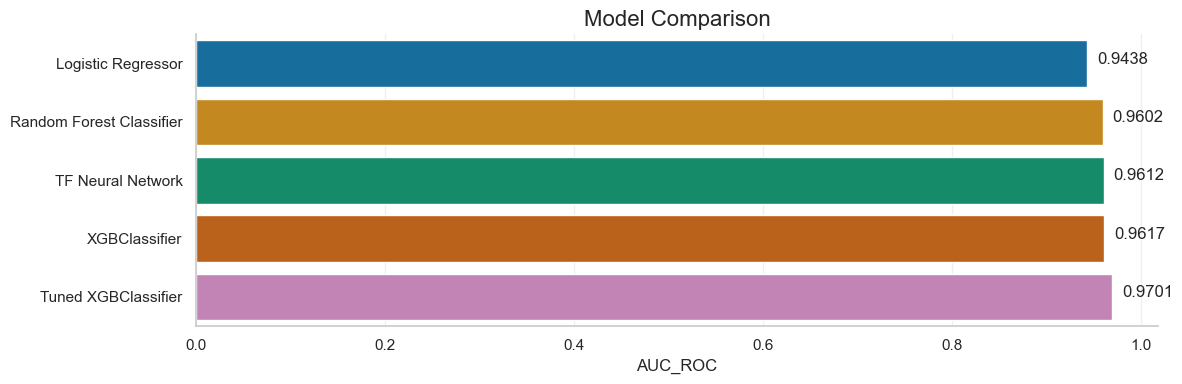

In [166]:
# Sort dataframe by the metric
performance.sort_values('AUC_ROC', inplace=True)

# Plot model metrics
ax = sns.barplot(data=performance, 
                 x='AUC_ROC', 
                 y=performance.index.tolist())

# Add data labels to the bars
for i, v in enumerate(performance['AUC_ROC']):
    ax.text(v + 0.01, i, str(round(v, 4)))

ax.set_title('Model Comparison')

plt.tight_layout()
plt.show()

<a name="7"></a>
# Model Diagnostic

Diagnostic the fit of the best performing models

## Feature Importance

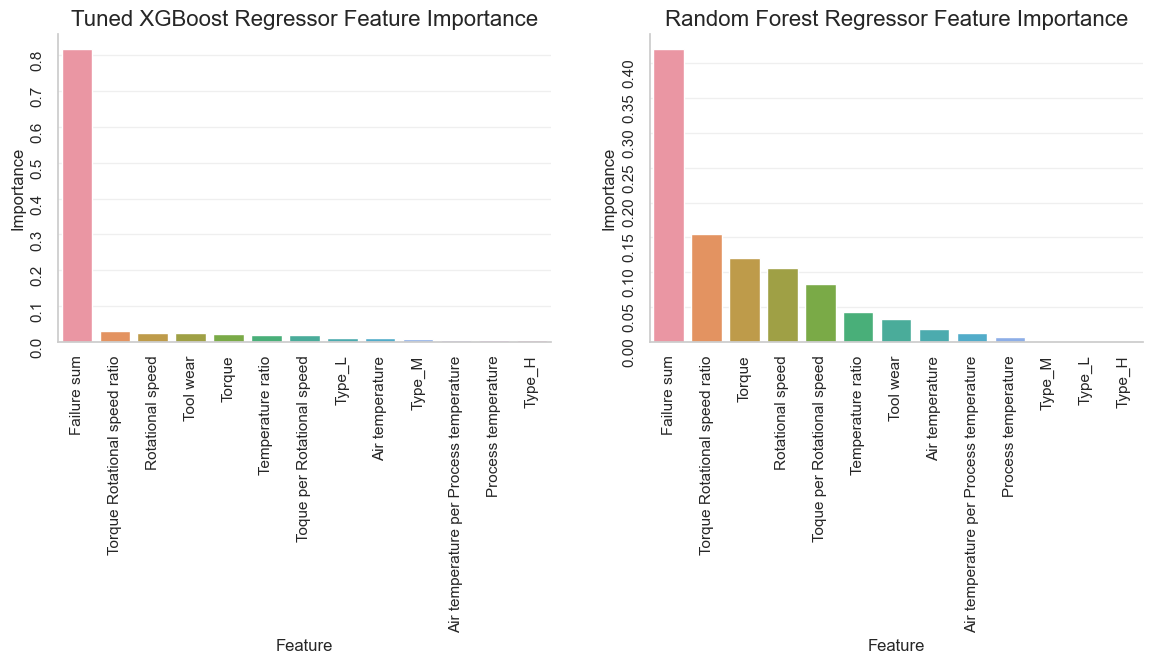

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Compute the feature importance
importances_xgbc = sorted(list(zip(model_best_xgbc.feature_names_in_,
                              model_best_xgbc.feature_importances_)))

# Transform it into a DataFrame
importances_xgbc_df = pd.DataFrame(importances_xgbc,
                                     columns= ['Feature', 'Importance'])

# Sorting importances
importances_xgbc_df = importances_xgbc_df.sort_values(['Importance'], ascending=False).reset_index(drop=True)

# Plot the feature importance
ax[0] = sns.barplot(data=importances_xgbc_df, 
                 x='Feature', 
                 y='Importance',
                 ax=ax[0])
ax[0].set_title('Tuned XGBoost Regressor Feature Importance')
ax[0].tick_params(labelrotation=90)

# Compute the feature importance
importances_rfc = sorted(list(zip(model_rfc.feature_names_in_,
                              model_rfc.feature_importances_)))

# Transform it into a DataFrame
importances_rfc_df = pd.DataFrame(importances_rfc,
                                     columns= ['Feature', 'Importance'])

# Sorting importances
importances_rfc_df = importances_rfc_df.sort_values(['Importance'], ascending=False).reset_index(drop=True)

# Plot the feature importance
ax[1] = sns.barplot(data=importances_rfc_df, 
                 x='Feature', 
                 y='Importance',
                 ax=ax[1])
ax[1].set_title('Random Forest Regressor Feature Importance')
ax[1].tick_params(labelrotation=90)

plt.show()

# Neural Network

Building a simple neural network with TenforFlow and Keras. 
2 layers, two with ReLU as activation funciton and the last one with a linear activation function (instead of a sigmoid, to increase numerical accuracy of prefictions. The probabilities will be calculated later with BinaryCrossentropy function, setting from_logits=True while compiling the model.

In [183]:
full_train_data.columns

Index(['Product ID', 'Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear', 'Machine failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Air temperature per Process temperature',
       'Temperature ratio', 'Toque per Rotational speed',
       'Torque Rotational speed ratio', 'Failure sum'],
      dtype='object')

In [198]:
# Set random seed
tf.random.set_seed(108)

# Define Neural Network Architecture
model_tf = Sequential(
    [               
        Dense(26, input_shape=(13,), activation='relu', name='L1'),
        Dense(13, activation='relu', name='L3'),
        Dense(7, activation='relu', name='L5'),
        Dense(1, activation='linear', name='L6'),
    ]
)

In [199]:
model_tf.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 26)                364       
                                                                 
 L3 (Dense)                  (None, 13)                351       
                                                                 
 L5 (Dense)                  (None, 7)                 98        
                                                                 
 L6 (Dense)                  (None, 1)                 8         
                                                                 
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________


In [200]:
%%time

model_tf.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model_tf.fit(
    X_train, 
    y_train,
    epochs=10
)

Epoch 1/10
3066/3066 [==============================] - 13s 4ms/step - loss: 0.0371
Epoch 2/10
3066/3066 [==============================] - 11s 3ms/step - loss: 0.0260
Epoch 3/10
3066/3066 [==============================] - 11s 3ms/step - loss: 0.0249
Epoch 4/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0246
Epoch 5/10
3066/3066 [==============================] - 11s 3ms/step - loss: 0.0243
Epoch 6/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0241
Epoch 7/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0238
Epoch 8/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0236
Epoch 9/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0233
Epoch 10/10
3066/3066 [==============================] - 10s 3ms/step - loss: 0.0233
CPU times: total: 2min 42s
Wall time: 1min 46s


In [201]:
# Generate Prediction
y_pred_tf = model_tf.predict(X_test)

roc_auc_tf = roc_auc_score(y_test, y_pred_tf)
print('AUC_ROC: {}'.format(roc_auc_tf))

1511/1511 [==============================] - 4s 3ms/step
AUC_ROC: 0.9582019052066661


In [202]:
# Update 'performance' DataFrame
performance.loc['TF Neural Network'] = [roc_auc_tf]

<a name="8"></a>
# Challenge Submission

In [178]:
# Generate predictions with test set with the besst performing model (based on ROC_AUC)
submission_predictions = model_tf.predict(transformed_test_data).flatten()

2843/2843 [==============================] - 6s 2ms/step


In [180]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data.index, 'Machine failure': submission_predictions})

In [181]:
submission.head()

,id,Machine failure
0,136429,-6.650907
1,136430,-6.064493
2,136431,-7.190914
3,136432,-7.160657
4,136433,-6.040459


In [182]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)